In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import datetime
import time

# ----- User Settings 

coins=['BTC']  # Only BTC is available at cryptocompare

collectDataFrom = pd.Timestamp('2012-02-01')


cryptocompare_api_key='777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'
requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']

# ----- User Settings -- end

limit=2000
coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while collectDataFrom <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addressesCount'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
        df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}-{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], df.loc[vindex,['balance_distribution']][0][i]['to'])
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "all"
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[collectDataFrom:]
df.sort_index(inplace=True)
df

Request : https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym=BTC&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1673479782.766468&limit=2000
Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1673479782.766468&limit=2000
Request : https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym=BTC&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1500508800.0&limit=2000
Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1500508800.0&limit=2000


coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2012-02-01           292281     3.029392          40050    107.350993   
2012-02-02           292266     3.003350          40198    107.822188   
2012-02-03           292491     3.043188          40454    108.551579   
2012-02-04           292450     3.019171          40485    108.980894   
2012-02-05           292366     3.011876          40594    109.471261   
...                     ...          ...            ...           ...   
2023-01-05         21751570  4341.340810       10325273  38638.996098   
2023-01-06         21757139  4332.789776       10336041  38674.572626   
2023-01-07         21770604  4336.806721       10363789  38773.810380   
2023-01-08         21784470  4342.239357       10385696  38845.657641   
2023-01-09         21816317  4345.017938       10361200  38692.522460   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2012-02-01            85663    2774.168003          39185  1.518235e+04   
2012-02-02            85843    2781.087397          39366  1.524673e+04   
2012-02-03            85519    2778.126810          39403  1.526407e+04   
2012-02-04            85508    2780.165933          39606  1.532373e+04   
2012-02-05            85548    2781.023910          39740  1.538108e+04   
...                     ...            ...            ...           ...   
2023-01-05          7227217  243831.964647        3227680  1.003012e+06   
2023-01-06          7234155  244196.939652        3231008  1.004064e+06   
2023-01-07          7243073  244530.537162        3232496  1.004599e+06   
2023-01-08          7248296  244654.196536        3229979  1.003886e+06   
2023-01-09          7248706  244821.538727        3231184  1.004436e+06   

coin                                       ...                               \
wallet_range           1-10                ...        10-100       100-1000   
metrics      addressesCount   totalVolume  ...   totalVolume addressesCount   
time                                       ...                                
2012-02-01            48911  1.494363e+05  ...  1.263377e+06           6498   
2012-02-02            49016  1.499425e+05  ...  1.267162e+06           6498   
2012-02-03            49220  1.506881e+05  ...  1.274734e+06           6502   
2012-02-04            49403  1.505996e+05  ...  1.268625e+06           6489   
2012-02-05            49520  1.511681e+05  ...  1.269442e+06           6479   
...                     ...           ...  ...           ...            ...   
2023-01-05           824328  2.062899e+06  ...  4.429659e+06          14082   
2023-01-06           824524  2.063164e+06  ...  4.429815e+06          14082   
2023-01-07           824339  2.062844e+06  ...  4.429792e+06          14087   
2023-01-08           824259  2.063650e+06  ...  4.429416e+06          14085   
2023-01-09           825834  2.064886e+06  ...  4.430950e+06          14083   

coin                                                                    \
wallet_range                   1000-10000                 10000-100000   
metrics        totalVolume addressesCount   totalVolume addressesCount   
time                                                                     
2012-02-01    1.597666e+06            730  1.869875e+06             69   
2012-02-02    1.596697e+06            728  1.871095e+06             69   
2012-02-03    1.588025e+06            732  1.879368e+06             69   
2012-02-04    1.588040e+06            732  1.885792e+06             69   


In [2]:
df_aux = pd.DataFrame()
#df_aux2 = pd.DataFrame()
coin = 'BTC'

aggregate_wallets=['0.1-1','1-10', '10-100','100-1000', '1000-10000', '10000-100000', '100000-0']


addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.1-0','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.01-0.1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.01-0','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.001-0.01')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.001-0','addressesCount')] = df_aux['addressesCount']
df.drop(columns=['1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


df

coin                BTC                                             
wallet_range        all          0.1-0         0.01-0        0.001-0
metrics           price addressesCount addressesCount addressesCount
time                                                                
2012-02-01        6.076         129652         215315         255365
2012-02-02        6.100         130040         215883         256081
2012-02-03        5.959         130543         216062         256516
2012-02-04        5.873         130751         216259         256744
2012-02-05        5.689         131029         216577         257171
...                 ...            ...            ...            ...
2023-01-05    16825.870        4207182       11434399       21759672
2023-01-06    16946.160        4210777       11444932       21780973
2023-01-07    16942.730        4212066       11455139       21818928
2023-01-08    17115.810        4209451       11457747       21843443
2023-01-09    17179.030        4212291       11460997       21822197

[3996 rows x 4 columns]

In [3]:
def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest')  # returns absolute index into df e.g. array([5])
    loc_idx = df.index[iloc_idx]                             # if you want named index
    # my_val = df.iloc[iloc_idx]
    return df.loc[loc_idx,'WM2NS'].values[0] 
df_m2 = pd.read_csv('data/WM2NS.csv')
df_m2['DATE']= pd.to_datetime(df_m2['DATE'])
df_m2.set_index(['DATE'],inplace=True, verify_integrity = True, drop = True)
df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))

btc_birthday = pd.to_datetime('2009-01-03')
m2_supply_at_genesis = convert_to_m2(df_m2,btc_birthday)
df.loc(axis=1)[('USD','all', 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_genesis
df.loc(axis=1)[('BTC','all', 'm2_adj_price')] = df.loc(axis=1)[('BTC','all', 'price')] /df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df


coin                BTC                                               \
wallet_range        all          0.1-0         0.01-0        0.001-0   
metrics           price addressesCount addressesCount addressesCount   
time                                                                   
2012-02-01        6.076         129652         215315         255365   
2012-02-02        6.100         130040         215883         256081   
2012-02-03        5.959         130543         216062         256516   
2012-02-04        5.873         130751         216259         256744   
2012-02-05        5.689         131029         216577         257171   
...                 ...            ...            ...            ...   
2023-01-05    16825.870        4207182       11434399       21759672   
2023-01-06    16946.160        4210777       11444932       21780973   
2023-01-07    16942.730        4212066       11455139       21818928   
2023-01-08    17115.810        4209451       11457747       21843443   
2023-01-09    17179.030        4212291       11460997       21822197   

coin               USD                          BTC  
wallet_range       all                          all  
metrics      m2_supply m2_supply_index m2_adj_price  
time                                                 
2012-02-01      9677.5        1.161486     5.231230  
2012-02-02      9677.5        1.161486     5.251894  
2012-02-03      9764.7        1.171952     5.084681  
2012-02-04      9764.7        1.171952     5.011299  
2012-02-05      9764.7        1.171952     4.854296  
...                ...             ...          ...  
2023-01-05     21370.0        2.564810  6560.278373  
2023-01-06     21370.0        2.564810  6607.178527  
2023-01-07     21370.0        2.564810  6605.841196  
2023-01-08     21370.0        2.564810  6673.323768  
2023-01-09     21370.0        2.564810  6697.972764  

[3996 rows x 7 columns]

In [4]:
df.loc(axis=1)[(coin,'0.1-0','k')] = 21000000*df.loc(axis=1)[(coin,'all','m2_adj_price')] / ( df.loc(axis=1)[(coin,'0.1-0','addressesCount')]
                                                                              * df.loc(axis=1)[(coin,'0.1-0','addressesCount')])

df.loc(axis=1)[(coin,'0.01-0','k')] = 21000000*df.loc(axis=1)[(coin,'all','m2_adj_price')] / ( df.loc(axis=1)[(coin,'0.01-0','addressesCount')]
                                                                              * df.loc(axis=1)[(coin,'0.01-0','addressesCount')])
df.loc(axis=1)[(coin,'0.001-0','k')] = 21000000*df.loc(axis=1)[(coin,'all','m2_adj_price')] / ( df.loc(axis=1)[(coin,'0.001-0','addressesCount')]
                                                                              * df.loc(axis=1)[(coin,'0.001-0','addressesCount')])


df.loc(axis=1)[(coin,'0.001-0', 'k-sma200w')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(200*7).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma200w')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(200*7).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma200w')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(200*7).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma50w')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(50*7).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma50w')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(50*7).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma50w')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(50*7).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma21w')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(21*7).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma21w')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(21*7).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma21w')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(21*7).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma90d')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(90).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma90d')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(90).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma90d')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(90).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(30).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(30).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(30).mean()

# df=df.loc['2013-01-01':]

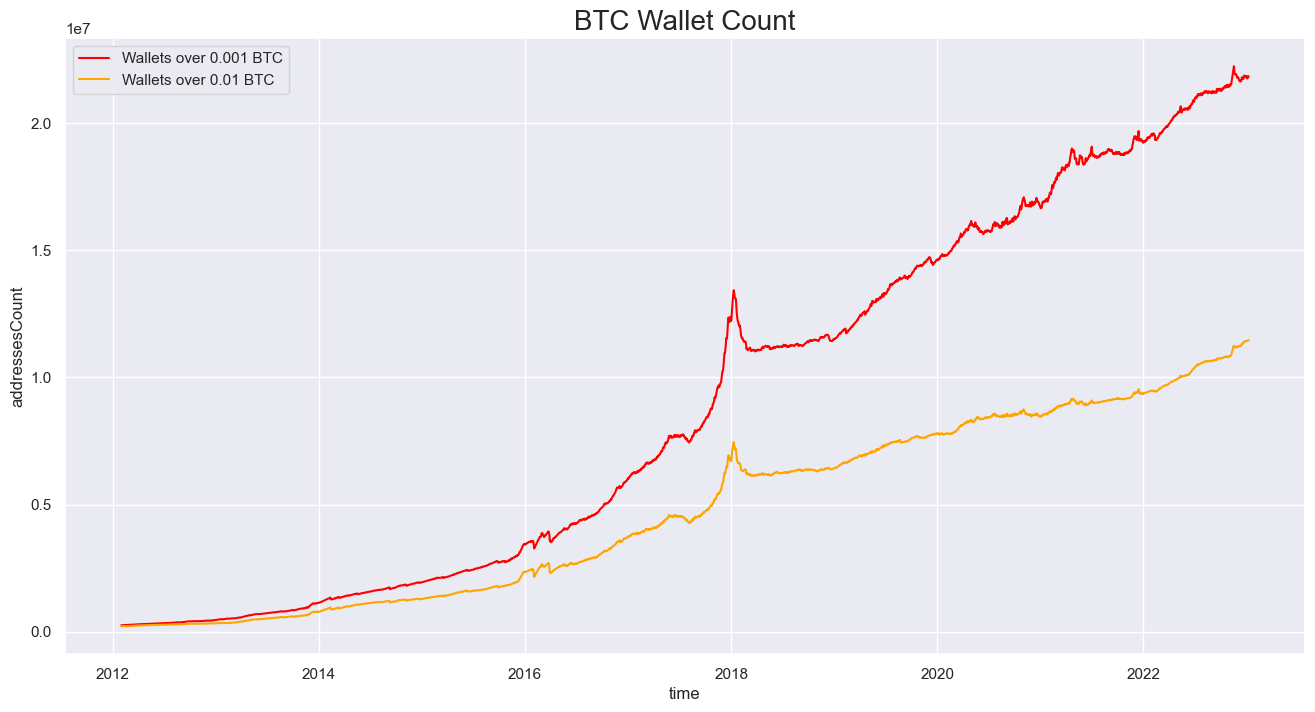

In [5]:
# Apply the default theme
import matplotlib.pyplot as plot
import seaborn as sns
coin='BTC'
sns.set_theme( palette="pastel")
sns.set(rc = {'figure.figsize':(16,8)})

plot.title("{} Wallet Count".format(coin), fontsize=20)

g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['addressesCount'], color='red',label='Wallets over 0.001 {}'.format(coin))
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0']['addressesCount'], color='orange',label='Wallets over 0.01 {}'.format(coin))

#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0.01']['addressesCount'], color='blue',label='0.001-0.01 Wallets')
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0.1']['addressesCount'], color='green',label='0.01-0.1 Wallets')
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.1-1']['addressesCount'], color='red',label='0.1-1 Wallets')


#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin][buyAbove], color='red', label=buyAbove)
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['trade_usd_value'], color='blue', label='Trading Value {}'.format(buyAbove),linewidth=1)

#g_results.set(yscale='log')
#plot.legend()

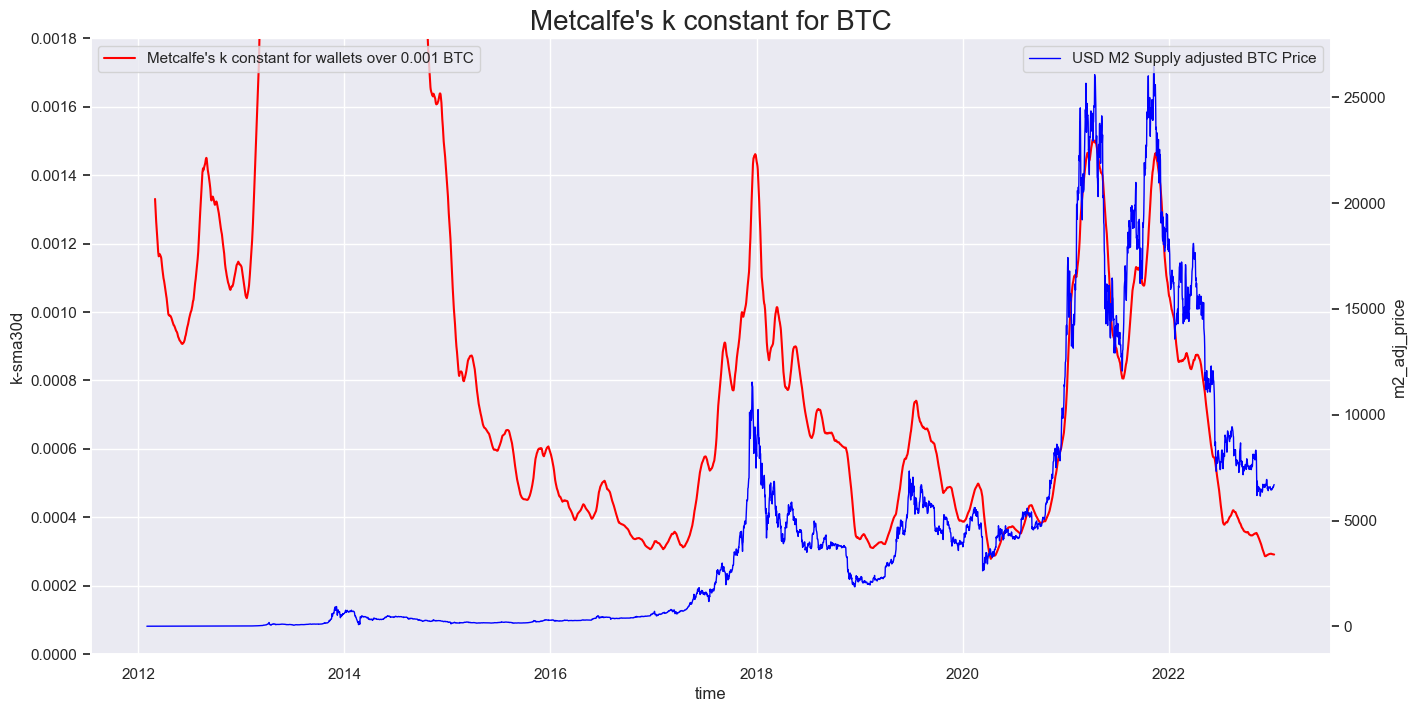

In [6]:
#plot.title("{} k".format(coin), fontsize=20)
fig, ax = plot.subplots()

plot.title("Metcalfe's k constant for {}".format(coin), fontsize=20)

ax.set_ylim(0, 0.0018)
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['addressesCount'], color='red',label='Wallets over 0.001 {}'.format(coin))
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0']['k-sma30d'], color='orange',label='Metcalfe\'s k constant for wallets over 0.01 {}'.format(coin))
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['k-sma30d'], color='red',label='Metcalfe\'s k constant for wallets over 0.001 {}'.format(coin))
#g_results.set(yscale='log')
plot.legend(loc='upper left')
ax2 = plot.twinx()
ax2.grid(False)

g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['all']['m2_adj_price'], linewidth=1, color='blue',label='USD M2 Supply adjusted {} Price'.format(coin))
x = ax2.legend(loc='upper right')


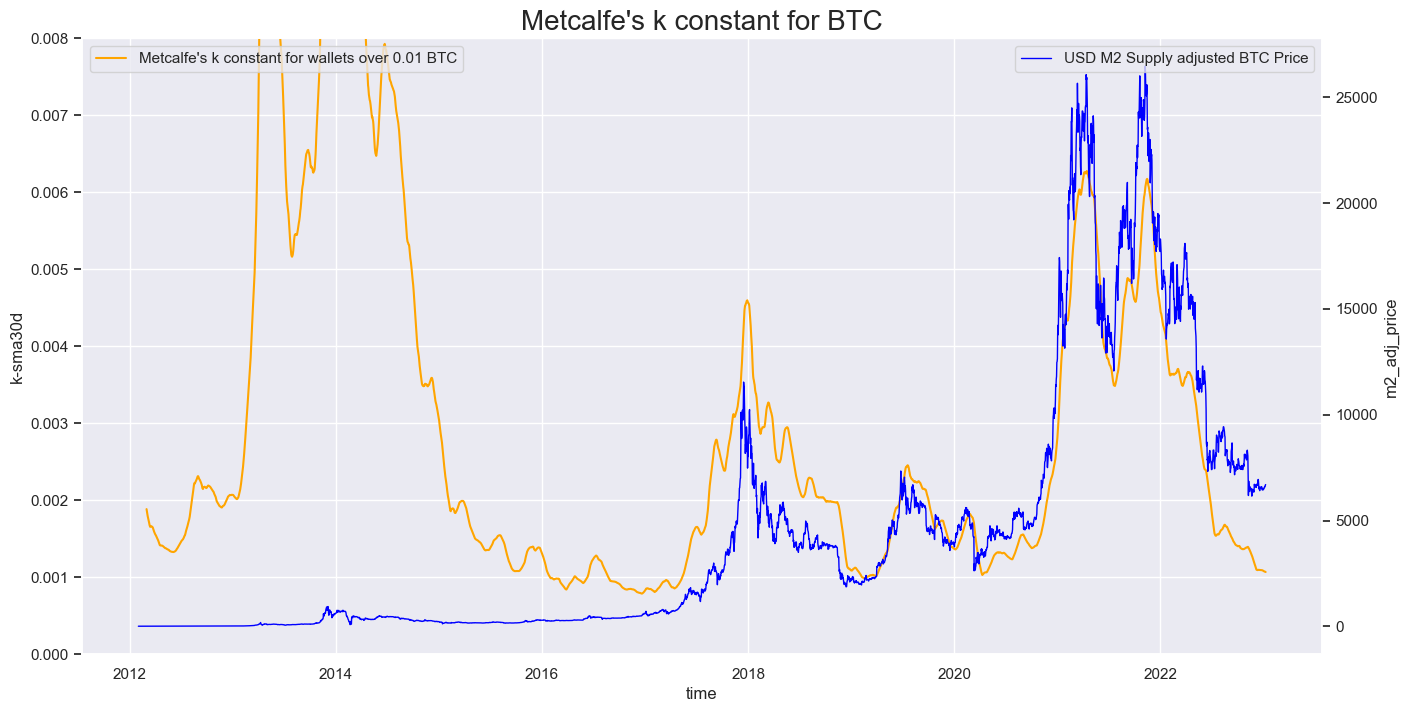

In [7]:
#plot.title("{} k".format(coin), fontsize=20)
fig, ax = plot.subplots()

plot.title("Metcalfe's k constant for {}".format(coin), fontsize=20)

ax.set_ylim(0, 0.008)
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0']['k-sma30d'], color='orange',label='Metcalfe\'s k constant for wallets over 0.01 {}'.format(coin))
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['k-sma30d'], color='red',label='Metcalfe\'s k constant for wallets over 0.001 {}'.format(coin))
#g_results.set(yscale='log')
plot.legend(loc='upper left')
ax2 = plot.twinx()
ax2.grid(False)

g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['all']['m2_adj_price'], linewidth=1, color='blue',label='USD M2 Supply adjusted {} Price'.format(coin))
x = ax2.legend(loc='upper right')


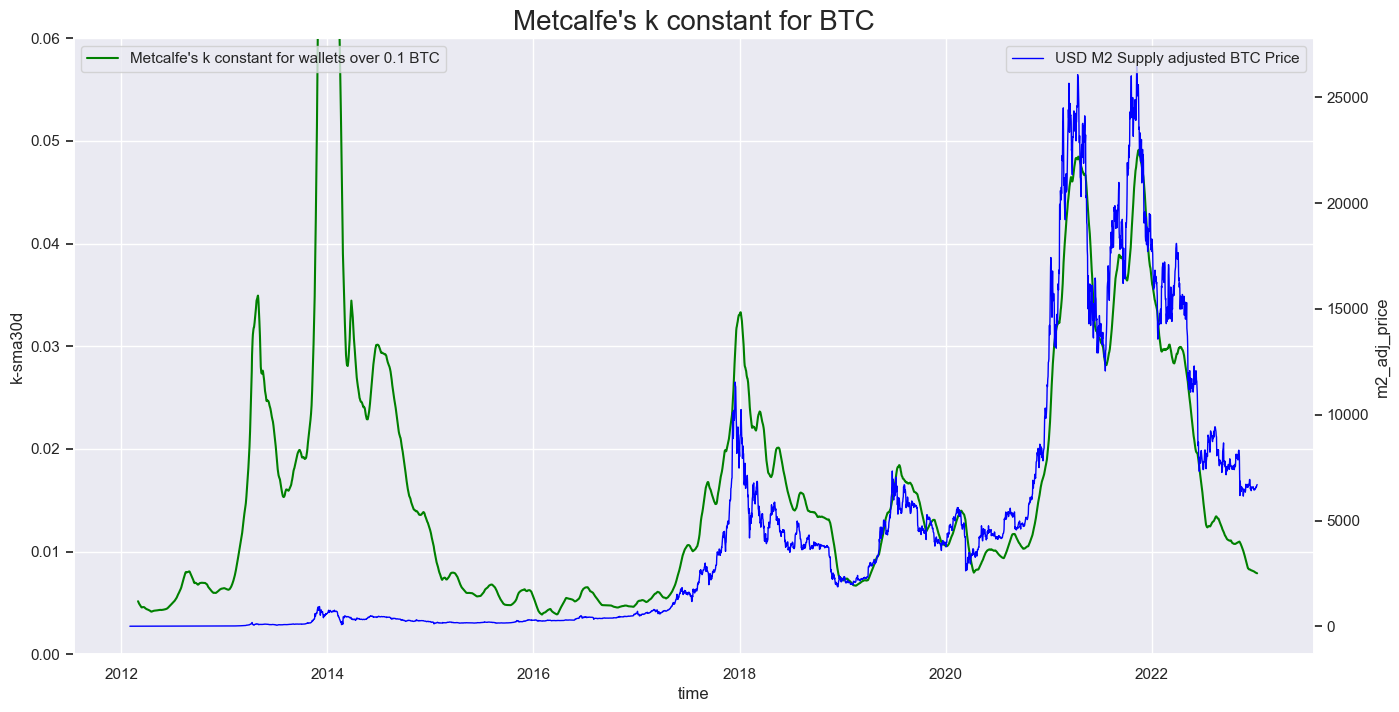

In [8]:
#plot.title("{} k".format(coin), fontsize=20)
fig, ax = plot.subplots()

plot.title("Metcalfe's k constant for {}".format(coin), fontsize=20)

ax.set_ylim(0, 0.06)
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.1-0']['k-sma30d'], color='green',label='Metcalfe\'s k constant for wallets over 0.1 {}'.format(coin))
#g_results.set(yscale='log')
plot.legend(loc='upper left')
ax2 = plot.twinx()
ax2.grid(False)

g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['all']['m2_adj_price'], linewidth=1, color='blue',label='USD M2 Supply adjusted {} Price'.format(coin))
x = ax2.legend(loc='upper right')
